In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

max_images = 200
batch_size = 2048
learning_rate = .001
num_epochs = 25

In [3]:
#GET TARGET DATA

def get_mask(file):
    data = np.load(file)
    bands = data['rad'].reshape(128 * 128, 16)
    cloud_mask = data['l2_cloud_mask'].flatten().reshape(-1, 1)
    return bands, cloud_mask

In [5]:
#CREATE DATASET

file_list = glob.glob('../ABI_Data/*.npz')

X = []
y = []

for i, file in enumerate(file_list):
    features, target = get_mask(file)
    X.append(features)
    y.append(target)
    if i == max_images: break

X = torch.from_numpy(np.concatenate(X, axis=0))
y = torch.from_numpy(np.concatenate(y, axis=0)).long().squeeze() #Long for CrossEntropy

dataset = TensorDataset(X, y)

In [6]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
#CREATE MODEL

class FeedForwardClassifier(nn.Module):
    def __init__(self, input_dim=16, output_dim=2):
        super(FeedForwardClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

num_classes = 2
model = FeedForwardClassifier(output_dim = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [10]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = correct = total = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    train_loss /= total
    final_acc = correct / total
    return train_loss, final_acc


def eval(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= total
    final_acc = correct / total

    return val_loss, final_acc

In [11]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 1287/1287 [00:22<00:00, 58.11it/s]


Epoch: 1 | Train Loss: 0.8580 | Train Acc: 0.8289 | Val Loss: 0.3178 | Val Acc: 0.8381


100%|██████████| 1287/1287 [00:16<00:00, 77.05it/s]


Epoch: 2 | Train Loss: 0.2985 | Train Acc: 0.8649 | Val Loss: 0.2871 | Val Acc: 0.8728


100%|██████████| 1287/1287 [00:16<00:00, 77.51it/s]


Epoch: 3 | Train Loss: 0.2815 | Train Acc: 0.8777 | Val Loss: 0.2660 | Val Acc: 0.8909


100%|██████████| 1287/1287 [00:16<00:00, 77.81it/s]


Epoch: 4 | Train Loss: 0.2659 | Train Acc: 0.8882 | Val Loss: 0.2653 | Val Acc: 0.8873


100%|██████████| 1287/1287 [00:16<00:00, 77.79it/s]


Epoch: 5 | Train Loss: 0.2606 | Train Acc: 0.8924 | Val Loss: 0.2760 | Val Acc: 0.8743


100%|██████████| 1287/1287 [00:16<00:00, 77.22it/s]


Epoch: 6 | Train Loss: 0.2496 | Train Acc: 0.8978 | Val Loss: 0.2345 | Val Acc: 0.9092


100%|██████████| 1287/1287 [00:16<00:00, 77.80it/s]


Epoch: 7 | Train Loss: 0.2423 | Train Acc: 0.9014 | Val Loss: 0.2394 | Val Acc: 0.9013


100%|██████████| 1287/1287 [00:17<00:00, 75.34it/s]


Epoch: 8 | Train Loss: 0.2387 | Train Acc: 0.9035 | Val Loss: 0.2382 | Val Acc: 0.9062


100%|██████████| 1287/1287 [00:17<00:00, 75.61it/s]


Epoch: 9 | Train Loss: 0.2329 | Train Acc: 0.9055 | Val Loss: 0.2463 | Val Acc: 0.8968


100%|██████████| 1287/1287 [00:17<00:00, 75.66it/s]


Epoch: 10 | Train Loss: 0.2277 | Train Acc: 0.9075 | Val Loss: 0.2366 | Val Acc: 0.9013


100%|██████████| 1287/1287 [00:17<00:00, 75.02it/s]


Epoch: 11 | Train Loss: 0.2252 | Train Acc: 0.9078 | Val Loss: 0.2367 | Val Acc: 0.8945


100%|██████████| 1287/1287 [00:16<00:00, 76.00it/s]


Epoch: 12 | Train Loss: 0.2181 | Train Acc: 0.9109 | Val Loss: 0.2106 | Val Acc: 0.9132


100%|██████████| 1287/1287 [00:17<00:00, 75.24it/s]


Epoch: 13 | Train Loss: 0.2163 | Train Acc: 0.9111 | Val Loss: 0.2105 | Val Acc: 0.9134


100%|██████████| 1287/1287 [00:17<00:00, 74.64it/s]


Epoch: 14 | Train Loss: 0.2136 | Train Acc: 0.9122 | Val Loss: 0.2020 | Val Acc: 0.9172


100%|██████████| 1287/1287 [00:17<00:00, 75.24it/s]


Epoch: 15 | Train Loss: 0.2083 | Train Acc: 0.9138 | Val Loss: 0.2144 | Val Acc: 0.9090


100%|██████████| 1287/1287 [00:17<00:00, 74.46it/s]


Epoch: 16 | Train Loss: 0.2080 | Train Acc: 0.9135 | Val Loss: 0.2004 | Val Acc: 0.9180


100%|██████████| 1287/1287 [00:17<00:00, 75.62it/s]


Epoch: 17 | Train Loss: 0.2036 | Train Acc: 0.9149 | Val Loss: 0.1953 | Val Acc: 0.9212


100%|██████████| 1287/1287 [00:16<00:00, 75.98it/s]


Epoch: 18 | Train Loss: 0.2024 | Train Acc: 0.9151 | Val Loss: 0.1947 | Val Acc: 0.9180


100%|██████████| 1287/1287 [00:16<00:00, 76.49it/s]


Epoch: 19 | Train Loss: 0.1998 | Train Acc: 0.9158 | Val Loss: 0.1917 | Val Acc: 0.9185


100%|██████████| 1287/1287 [00:17<00:00, 74.08it/s]


Epoch: 20 | Train Loss: 0.1976 | Train Acc: 0.9164 | Val Loss: 0.1948 | Val Acc: 0.9171


100%|██████████| 1287/1287 [00:17<00:00, 75.48it/s]


Epoch: 21 | Train Loss: 0.1957 | Train Acc: 0.9168 | Val Loss: 0.1972 | Val Acc: 0.9136


100%|██████████| 1287/1287 [00:16<00:00, 76.57it/s]


Epoch: 22 | Train Loss: 0.1925 | Train Acc: 0.9185 | Val Loss: 0.2085 | Val Acc: 0.9100


100%|██████████| 1287/1287 [00:16<00:00, 77.30it/s]


Epoch: 23 | Train Loss: 0.1904 | Train Acc: 0.9193 | Val Loss: 0.2294 | Val Acc: 0.9126


100%|██████████| 1287/1287 [00:16<00:00, 77.54it/s]


Epoch: 24 | Train Loss: 0.1884 | Train Acc: 0.9202 | Val Loss: 0.1812 | Val Acc: 0.9228


100%|██████████| 1287/1287 [00:16<00:00, 77.54it/s]


Epoch: 25 | Train Loss: 0.1874 | Train Acc: 0.9205 | Val Loss: 0.1902 | Val Acc: 0.9223


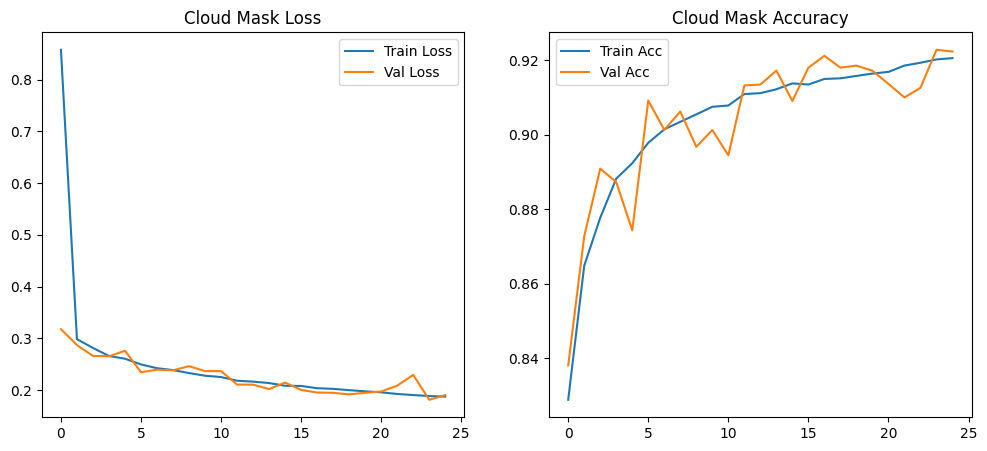

In [13]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Cloud Mask Accuracy')
plt.legend()

plt.savefig("./graphs/mlp_cloud_mask.png")  

plt.show()

In [14]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

print("REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted:", np.mean(iou))
print("Weighted:", np.average(iou, weights=supports))

100%|██████████| 161/161 [00:01<00:00, 82.32it/s] 


REPORT:
               precision    recall  f1-score   support

           0      0.793     0.889     0.839     76014
           1      0.966     0.931     0.948    253305

    accuracy                          0.921    329319
   macro avg      0.880     0.910     0.893    329319
weighted avg      0.926     0.921     0.923    329319

CONFUSION MATRIX:
 [[ 67606   8408]
 [ 17594 235711]]

IOU: [0.7222246  0.90064689]
Unweighted: 0.8114357440063051
Weighted: 0.8594631387445114
